# 1. Data Collection

## 1.1 Import all Necessary Packages

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

import folium
from folium import plugins
from folium.plugins import HeatMap

import requests

from datetime import date, time, datetime, timedelta

## 1.2 Import the Raw Data

In [2]:
data = pd.read_csv("philadelphia_2019.csv")
weatherData = pd.read_csv("weather_hourly_philadelphia.csv")

## 1.3 Get an Overview over the Dataset

In [3]:
data.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
0,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park"
1,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park"
2,2019-01-01 00:52:00,2019-01-01 01:05:00,3166,3169,14623,Indego30,Frankford & Belgrade,2nd & Race
3,2019-01-01 00:55:00,2019-01-01 01:04:00,3058,3103,11706,Indego30,20th & Fairmount,"27th & Master, Athletic Recreation Center"
4,2019-01-01 01:05:00,2019-01-01 01:17:00,3182,3028,11039,Indego30,17th & Sansom,4th & Bainbridge


In [4]:
data.describe()

,start_station_id,end_station_id,bike_id
count,744260.000000,744260.000000,744260.000000
mean,3081.936112,3081.409467,9825.729611
std,58.702453,59.296591,5404.388722
min,3000.000000,3000.000000,1.000000
25%,3033.000000,3032.000000,3729.000000
50%,3062.000000,3062.000000,11744.000000
75%,3123.000000,3124.000000,14592.000000
max,3210.000000,3210.000000,20265.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744260 entries, 0 to 744259
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   start_time          744260 non-null  object
 1   end_time            744260 non-null  object
 2   start_station_id    744260 non-null  int64 
 3   end_station_id      744260 non-null  int64 
 4   bike_id             744260 non-null  int64 
 5   user_type           744225 non-null  object
 6   start_station_name  744260 non-null  object
 7   end_station_name    744260 non-null  object
dtypes: int64(3), object(5)
memory usage: 45.4+ MB


In [6]:
# get all different user types

user_type_list = data['user_type'].unique()
user_type_list

array(['Indego30', 'Day Pass', 'Indego365', 'IndegoFlex', 'Walk-up', nan],
      dtype=object)

In [7]:
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_time  43785 non-null  object 
 1   max_temp   43785 non-null  float64
 2   min_temp   43785 non-null  float64
 3   precip     43785 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.3+ MB


In [8]:
weatherData.head()

,date_time,max_temp,min_temp,precip
0,2015-01-02 01:00:00,3.3,3.3,0.0
1,2015-01-02 02:00:00,2.8,2.8,0.0
2,2015-01-02 03:00:00,2.2,2.2,0.0
3,2015-01-02 04:00:00,0.6,0.6,0.0
4,2015-01-02 05:00:00,1.1,1.1,0.0


In [9]:
# Get total Fleet Size and Availability

fleet_size = len(data["bike_id"].unique())

print("The bike fleet from Indego consists of {} bikes (for the observed time frame)".format(fleet_size))

The bike fleet from Indego consists of 1677 bikes (for the observed time frame)


# 2. Data Preparation

## 2.1 Formatting and Adding Attributes

In [10]:
# make timestamps out of 'start_time' and 'end_time'

data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

In [11]:
# add durations of each ride

data['duration'] = data['end_time'] - data['start_time']

In [12]:
# Maps time of day and day of week to our DF

def get_date (ts):
    return ts.date()

def get_weekday (ts):
    return ts.weekday()

def get_hour (ts):
    return ts.hour

def get_minute (ts):
    return ts.minute


data["start_date"] = data["start_time"].apply(lambda ts: get_date (ts))
data["start_weekday"]=data["start_time"].apply(lambda x: get_weekday (x))
data["start_hour"]=data["start_time"].apply(lambda x: get_hour (x))
data["start_minute"]=data["start_time"].apply(lambda x: get_minute (x))

data["end_date"] = data["end_time"].apply(lambda ts: get_date (ts))
data["end_weekday"]=data["end_time"].apply(lambda x: get_weekday (x))
data["end_hour"]=data["end_time"].apply(lambda x: get_hour (x))
data["end_minute"]=data["end_time"].apply(lambda x: get_minute (x))

In [13]:
# adds column with verbosed weekday into DF

weekday_dict = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
data["weekday_verbose_start"] = data["start_weekday"].apply(lambda x: weekday_dict[x])
data["weekday_verbose_end"] = data["end_weekday"].apply(lambda x: weekday_dict[x])
data.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_date,start_weekday,start_hour,start_minute,end_date,end_weekday,end_hour,end_minute,weekday_verbose_start,weekday_verbose_end
0,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park",0 days 00:08:00,2019-01-01,1,0,19,2019-01-01,1,0,27,Tue,Tue
1,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park",0 days 00:07:00,2019-01-01,1,0,30,2019-01-01,1,0,37,Tue,Tue
2,2019-01-01 00:52:00,2019-01-01 01:05:00,3166,3169,14623,Indego30,Frankford & Belgrade,2nd & Race,0 days 00:13:00,2019-01-01,1,0,52,2019-01-01,1,1,5,Tue,Tue
3,2019-01-01 00:55:00,2019-01-01 01:04:00,3058,3103,11706,Indego30,20th & Fairmount,"27th & Master, Athletic Recreation Center",0 days 00:09:00,2019-01-01,1,0,55,2019-01-01,1,1,4,Tue,Tue
4,2019-01-01 01:05:00,2019-01-01 01:17:00,3182,3028,11039,Indego30,17th & Sansom,4th & Bainbridge,0 days 00:12:00,2019-01-01,1,1,5,2019-01-01,1,1,17,Tue,Tue


In [14]:
weatherData["date_time"] = pd.to_datetime(weatherData["date_time"])
weatherData["date"]=weatherData["date_time"].apply(lambda x: get_date (x))
weatherData["hour"]=weatherData["date_time"].apply(lambda x: get_hour (x))

## 2.2 Dealing with Missing Values

In [15]:
# get number of missing values

data.isnull().sum()

start_time                0
end_time                  0
start_station_id          0
end_station_id            0
bike_id                   0
user_type                35
start_station_name        0
end_station_name          0
duration                  0
start_date                0
start_weekday             0
start_hour                0
start_minute              0
end_date                  0
end_weekday               0
end_hour                  0
end_minute                0
weekday_verbose_start     0
weekday_verbose_end       0
dtype: int64

because there are only 35 out of 744260 rows with missing values, we can simply drop these rows

In [16]:
# drop rows with missing values

data_clean_temp = data.dropna(axis=0, inplace=False)

In [17]:
# get number of missing values from weather

weatherData.isnull().sum()

date_time    63
max_temp     63
min_temp     63
precip       63
date         63
hour         63
dtype: int64

In [18]:
# first we check if each column has null value, so no information gets lost

pd.set_option("display.max_rows", None, "display.max_columns", None)
weatherData_is_null = weatherData[weatherData['date_time'].isnull()]

print(weatherData_is_null)

      date_time  max_temp  min_temp  precip date  hour
1104        NaT       NaN       NaN     NaN  NaT   NaN
1111        NaT       NaN       NaN     NaN  NaT   NaN
1588        NaT       NaN       NaN     NaN  NaT   NaN
3973        NaT       NaN       NaN     NaN  NaT   NaN
4108        NaT       NaN       NaN     NaN  NaT   NaN
5752        NaT       NaN       NaN     NaN  NaT   NaN
6579        NaT       NaN       NaN     NaN  NaT   NaN
6604        NaT       NaN       NaN     NaN  NaT   NaN
6605        NaT       NaN       NaN     NaN  NaT   NaN
6606        NaT       NaN       NaN     NaN  NaT   NaN
9245        NaT       NaN       NaN     NaN  NaT   NaN
9769        NaT       NaN       NaN     NaN  NaT   NaN
10089       NaT       NaN       NaN     NaN  NaT   NaN
10492       NaT       NaN       NaN     NaN  NaT   NaN
19228       NaT       NaN       NaN     NaN  NaT   NaN
20336       NaT       NaN       NaN     NaN  NaT   NaN
21579       NaT       NaN       NaN     NaN  NaT   NaN
23764     

In [19]:
#check if null-values dropped

weatherData_is_null.sum()

max_temp    0.0
min_temp    0.0
precip      0.0
date          0
hour        0.0
dtype: object

In [20]:
# Now we can drop columns with null values

weatherData_clean  = weatherData.dropna(axis=0, inplace=False)
weatherData_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43785 entries, 0 to 43847
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  43785 non-null  datetime64[ns]
 1   max_temp   43785 non-null  float64       
 2   min_temp   43785 non-null  float64       
 3   precip     43785 non-null  float64       
 4   date       43785 non-null  object        
 5   hour       43785 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 2.3+ MB


## 2.3 Dealing with Outliers

Possible outliers are rides with a very high or low duration

In [21]:
data_clean_temp.duration.describe()

count                       744225
mean     0 days 00:24:44.368654640
std      0 days 02:03:47.463561723
min              -1 days +23:06:39
25%                0 days 00:07:00
50%                0 days 00:11:00
75%                0 days 00:19:00
max               21 days 13:24:08
Name: duration, dtype: object

we can drop rows with a duration ≤ 0 or a duration > 3 standard deviations because these are not representative

In [22]:
# get rows with duration <= 0

low_duration = data_clean_temp.duration[data_clean_temp.duration <= pd.Timedelta(0)]
low_duration.count()

42

In [23]:
# get rows with duration > 3 standard deviations

high_duration = data_clean_temp.duration[(data_clean_temp.duration > 3*data_clean_temp.duration.std())]
high_duration.count()

4322

In [24]:
# drop these rows

data_clean_temp2 = data_clean_temp.drop(high_duration.index)
data_clean = data_clean_temp2.drop(low_duration.index)

In [25]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739861 entries, 0 to 744259
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   start_time             739861 non-null  datetime64[ns] 
 1   end_time               739861 non-null  datetime64[ns] 
 2   start_station_id       739861 non-null  int64          
 3   end_station_id         739861 non-null  int64          
 4   bike_id                739861 non-null  int64          
 5   user_type              739861 non-null  object         
 6   start_station_name     739861 non-null  object         
 7   end_station_name       739861 non-null  object         
 8   duration               739861 non-null  timedelta64[ns]
 9   start_date             739861 non-null  object         
 10  start_weekday          739861 non-null  int64          
 11  start_hour             739861 non-null  int64          
 12  start_minute           739861 

## 2.4 Merge weather and data set

In [26]:
# merge (left join)
data_merged_with_weather = data_clean.merge(weatherData_clean, left_on=['start_date', 'start_hour'], right_on=['date', 'hour'], how='left')
data_clean = data_merged_with_weather

In [27]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777931 entries, 0 to 777930
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   start_time             777931 non-null  datetime64[ns] 
 1   end_time               777931 non-null  datetime64[ns] 
 2   start_station_id       777931 non-null  int64          
 3   end_station_id         777931 non-null  int64          
 4   bike_id                777931 non-null  int64          
 5   user_type              777931 non-null  object         
 6   start_station_name     777931 non-null  object         
 7   end_station_name       777931 non-null  object         
 8   duration               777931 non-null  timedelta64[ns]
 9   start_date             777931 non-null  object         
 10  start_weekday          777931 non-null  int64          
 11  start_hour             777931 non-null  int64          
 12  start_minute           777931 

In [28]:
data_clean.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_date,start_weekday,start_hour,start_minute,end_date,end_weekday,end_hour,end_minute,weekday_verbose_start,weekday_verbose_end,date_time,max_temp,min_temp,precip,date,hour
0,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park",0 days 00:08:00,2019-01-01,1,0,19,2019-01-01,1,0,27,Tue,Tue,2019-01-01,7.2,6.7,1.0,2019-01-01,0.0
1,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park",0 days 00:08:00,2019-01-01,1,0,19,2019-01-01,1,0,27,Tue,Tue,2019-01-01,6.7,6.1,0.0,2019-01-01,0.0
2,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park",0 days 00:07:00,2019-01-01,1,0,30,2019-01-01,1,0,37,Tue,Tue,2019-01-01,7.2,6.7,1.0,2019-01-01,0.0
3,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park",0 days 00:07:00,2019-01-01,1,0,30,2019-01-01,1,0,37,Tue,Tue,2019-01-01,6.7,6.1,0.0,2019-01-01,0.0
4,2019-01-01 00:52:00,2019-01-01 01:05:00,3166,3169,14623,Indego30,Frankford & Belgrade,2nd & Race,0 days 00:13:00,2019-01-01,1,0,52,2019-01-01,1,1,5,Tue,Tue,2019-01-01,7.2,6.7,1.0,2019-01-01,0.0


# 3. Descriptive Analytics

## 3.1 Temporal Demand Patterns and Seasonality

### 3.1.1 Average Usage per Weekday

In [29]:
# Average trips by day of week 

bike_trips_weekday = data_clean.groupby(["start_date", "weekday_verbose_start"]).size().unstack(fill_value=0)
mean = ['mean']
bike_trips_mean_per_weekday = pd.DataFrame(bike_trips_weekday[["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]].mean(), columns=mean)

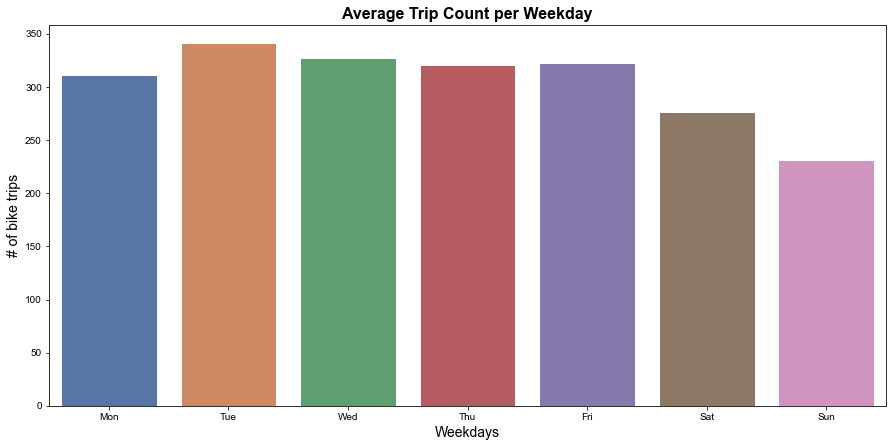

In [30]:
# plot

fig,ax = plt.subplots(figsize=(15,7)) 
sns.set_theme(style="darkgrid")
sns.barplot(x=bike_trips_mean_per_weekday.index, y='mean', data=bike_trips_mean_per_weekday, ax=ax)
ax.set_title('Average Trip Count per Weekday', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_ylabel("# of bike trips", fontsize=14)
ax.set_xlabel("Weekdays", fontsize=14)

plt.show()

**Analysis**
Here we can see that the average bike trips are higher on working days compared to the weekend (Saturday, Sunday).
On Tuesday is the maximum of average bike trips, followed by Wednesday. An explanation could be that on Tuesday an Wednesdays most people are working.

In [31]:
# bike trips over the day 

bike_trips_hourly = pd.DataFrame(data_clean).groupby(["start_date","start_hour"])["bike_id"].nunique()
bike_trips_hourly = pd.DataFrame(bike_trips_hourly)

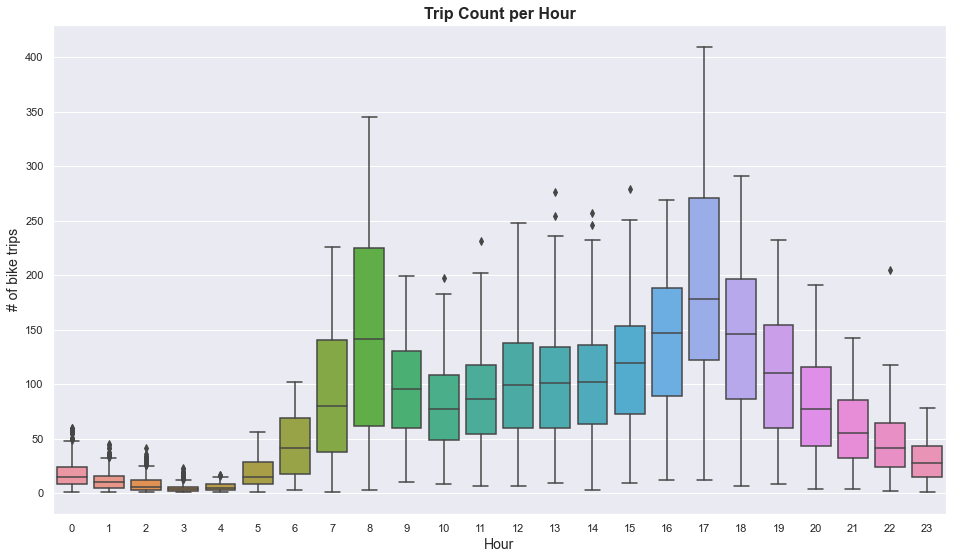

In [32]:
# plot

fig,ax = plt.subplots(figsize=(16,9)) 

sns.boxplot(x=bike_trips_hourly.index.get_level_values(1), y=bike_trips_hourly["bike_id"],ax=ax)
ax.set_title('Trip Count per Hour', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_ylabel("# of bike trips", fontsize=14)
ax.set_xlabel("Hour", fontsize=14)
plt.show()

### 3.1.2 Trip Duration per Weekday

[Text(0.5, 0, 'Weekdays'), Text(0, 0.5, 'Trip Duration in Seconds')]

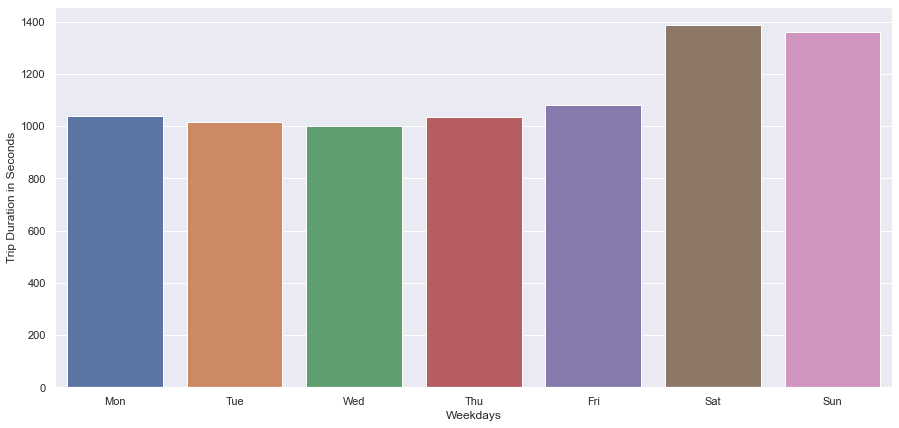

In [33]:
# get average trip duration per weekday

avg_duration_mon = data_clean.duration[(data_clean.start_weekday == 0)].sum() / data_clean.duration[(data_clean.start_weekday == 0)].count()
avg_duration_tue = data_clean.duration[(data_clean.start_weekday == 1)].sum() / data_clean.duration[(data_clean.start_weekday == 1)].count()
avg_duration_wed = data_clean.duration[(data_clean.start_weekday == 2)].sum() / data_clean.duration[(data_clean.start_weekday == 2)].count()
avg_duration_thu = data_clean.duration[(data_clean.start_weekday == 3)].sum() / data_clean.duration[(data_clean.start_weekday == 3)].count()
avg_duration_fri = data_clean.duration[(data_clean.start_weekday == 4)].sum() / data_clean.duration[(data_clean.start_weekday == 4)].count()
avg_duration_sat = data_clean.duration[(data_clean.start_weekday == 5)].sum() / data_clean.duration[(data_clean.start_weekday == 5)].count()
avg_duration_sun = data_clean.duration[(data_clean.start_weekday == 6)].sum() / data_clean.duration[(data_clean.start_weekday == 6)].count()


# make a Series with durations in seconds for plotting

avg_durations = pd.Series([avg_duration_mon, avg_duration_tue, avg_duration_wed, avg_duration_thu, avg_duration_fri, avg_duration_sat, avg_duration_sun], index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']).astype('timedelta64[s]')

# plot
fig,ax = plt.subplots(figsize=(15,7))
sns.set_theme(style="darkgrid")
plot = sns.barplot(x=avg_durations.index, y=avg_durations)
plot.set(xlabel='Weekdays', ylabel='Trip Duration in Seconds')

**Analysis**
Here we can see, that the average trip duration is higher on weekends

### 3.1.3 Seasonal Usage

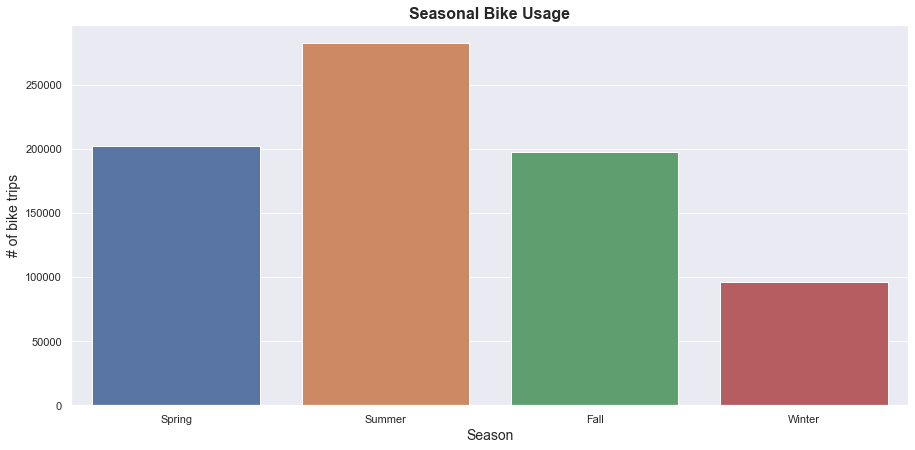

In [34]:
# set the time to when each season ends

time_winter_starts = pd.to_datetime("2019-12-21 00:00:00")
time_winter_ends = pd.to_datetime("2019-3-20 23:59:59")

time_spring_starts = pd.to_datetime("2019-3-21 00:00:00")
time_spring_ends = pd.to_datetime("2019-6-20 23:59:59")

time_summer_starts = pd.to_datetime("2019-6-21 00:00:00")
time_summer_ends = pd.to_datetime("2019-9-20 23:59:59")

time_fall_starts = pd.to_datetime("2019-9-21 00:00:00")
time_fall_ends = pd.to_datetime("2019-12-20 23:59:59")

spring_usage_count = 0
summer_usage_count = 0
fall_usage_count = 0
winter_usage_count = 0

for time in data_clean.start_time:
    if(time >= time_winter_starts or time <= time_winter_ends):
        winter_usage_count += 1
    elif(time >= time_spring_starts and time <= time_spring_ends):
        spring_usage_count += 1
    elif(time >= time_summer_starts and time <= time_summer_ends):
        summer_usage_count += 1
    elif(time >= time_fall_starts and time <= time_fall_ends):
        fall_usage_count += 1

#print(spring_usage_count, summer_usage_count, fall_usage_count, winter_usage_count)
#check if values are equal:
#print(spring_usage_count+summer_usage_count+ fall_usage_count+winter_usage_count)
#print(data_clean.start_time.size)

# create a Series for plotting with the usage and the respective seasons as indizes
season_usage = pd.Series([spring_usage_count, summer_usage_count, fall_usage_count, winter_usage_count], index=['Spring', 'Summer', 'Fall', 'Winter'])

# plot
fig,ax = plt.subplots(figsize=(15,7)) 

sns.barplot(x=season_usage.index, y=season_usage)
ax.set_title('Seasonal Bike Usage', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_ylabel("# of bike trips", fontsize=14)
ax.set_xlabel("Season", fontsize=14)

plt.show()

### 3.1.4 Seasonal Patterns of Usage on Weekdays

### 3.1.5 Temperature and Usage Correlation

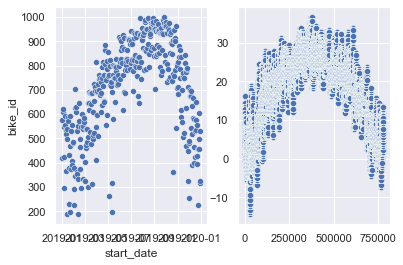

In [35]:
minmaxtemp = (data_clean["min_temp"] + data_clean["max_temp"])/2
bike_trips_daily = pd.DataFrame(data_clean).groupby(["start_date"])["bike_id"].nunique()

fig, ax = plt.subplots(ncols=2)

sns.scatterplot(x=bike_trips_daily.index, y=bike_trips_daily,ax=ax[0])
sns.scatterplot(x=minmaxtemp.index, y=minmaxtemp,ax=ax[1])
plt.show()

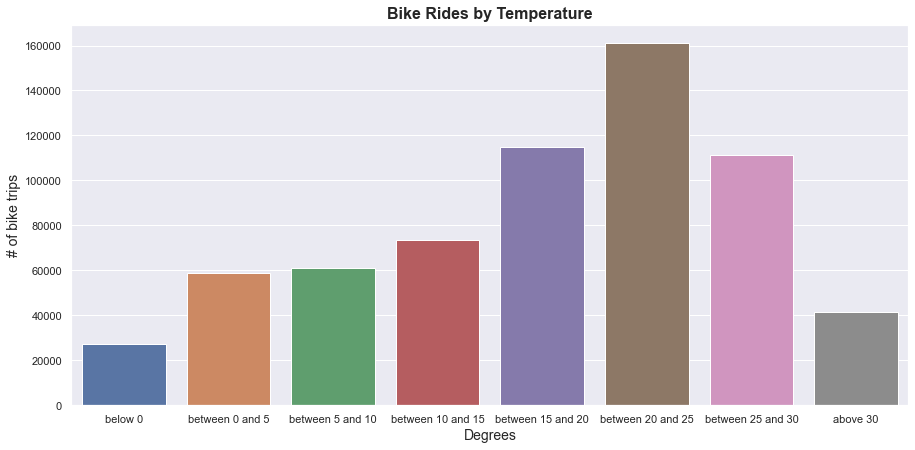

In [36]:
belowzero = 0
five = 0
ten = 0
fifteen = 0
twenty = 0
twentyfive = 0
thirty = 0
above = 0

for min_temp in data_clean.min_temp:
    if(min_temp <0):
        belowzero+=1
    elif(min_temp >0 and min_temp < 5):
        five+=1
    elif(min_temp >5 and min_temp < 10):
        ten+=1
    elif(min_temp >10 and min_temp < 15):
        fifteen+=1
    elif(min_temp >15 and min_temp < 20):
        twenty+=1
    elif(min_temp >20 and min_temp < 25):
        twentyfive+=1
    elif(min_temp >25 and min_temp < 30):
        thirty+=1
    elif(min_temp >30):
        above+=1

a = pd.Series([belowzero,five,ten,fifteen,twenty,twentyfive,thirty,above], 
              index=['below 0', 'between 0 and 5','between 5 and 10','between 10 and 15','between 15 and 20','between 20 and 25','between 25 and 30','above 30'])

fig,ax = plt.subplots(figsize=(15,7)) 

sns.barplot(x=a.index, y=a)
ax.set_title('Bike Rides by Temperature', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_ylabel("# of bike trips", fontsize=14)
ax.set_xlabel("Degrees", fontsize=14)

plt.show()

## 3.2 Geographical Demand Patterns

In [39]:
# request to indego api to get bike station data

api_address='https://kiosks.bicycletransit.workers.dev/phl'
response = requests.get(api_address).json()

In [40]:
# take the data into a dataframe and make it more readable
station_status = pd.DataFrame.from_dict(response)

station_status_clean = station_status['features'].apply(pd.Series)
station_status_clean = station_status_clean['properties'].apply(pd.Series)
station_status_clean

,id,name,coordinates,totalDocks,docksAvailable,bikesAvailable,classicBikesAvailable,smartBikesAvailable,electricBikesAvailable,rewardBikesAvailable,rewardDocksAvailable,kioskStatus,kioskPublicStatus,kioskConnectionStatus,kioskType,addressStreet,addressCity,addressState,addressZipCode,bikes,closeTime,eventEnd,eventStart,isEventBased,isVirtual,kioskId,notes,openTime,publicText,timeZone,trikesAvailable,latitude,longitude
0,3004,Municipal Services Building Plaza,"[-75.16374, 39.95378]",30,28,0,0,0,0,0,28,FullService,Active,Active,1,1401 John F. Kennedy Blvd.,Philadelphia,PA,19102,"[{'dockNumber': 17, 'isElectric': True, 'isAva...",None,None,None,False,False,3004,None,None,,None,0,39.95378,-75.16374
1,3005,"Welcome Park, NPS","[-75.14403, 39.94733]",13,11,2,1,0,1,2,11,FullService,Active,Active,1,191 S. 2nd St.,Philadelphia,PA,19106,"[{'dockNumber': 8, 'isElectric': False, 'isAva...",None,None,None,False,False,3005,None,None,,None,0,39.94733,-75.14403
2,3006,40th & Spruce,"[-75.20311, 39.9522]",17,14,2,2,0,0,2,14,FullService,Active,Active,1,246 S. 40th St.,Philadelphia,PA,19104,"[{'dockNumber': 4, 'isElectric': False, 'isAva...",None,None,None,False,False,3006,None,None,,None,0,39.95220,-75.20311
3,3007,"11th & Pine, Kahn Park","[-75.15993, 39.94517]",20,19,1,1,0,0,1,19,FullService,Active,Active,1,328 S. 11th St.,Philadelphia,PA,19107,"[{'dockNumber': 12, 'isElectric': False, 'isAv...",None,None,None,False,False,3007,None,None,,None,0,39.94517,-75.15993
4,3008,Temple University Station,"[-75.15114, 39.97944]",19,12,7,5,0,2,7,12,FullService,Active,Active,1,1076 Berks Street,Philadelphia,PA,19122,"[{'dockNumber': 5, 'isElectric': True, 'isAvai...",None,None,None,False,False,3008,None,None,,None,0,39.97944,-75.15114
5,3009,33rd & Market,"[-75.18982, 39.95576]",14,2,8,7,0,1,8,3,FullService,Active,Active,1,3318 Market St.,Philadelphia,PA,19104,"[{'dockNumber': 1, 'isElectric': False, 'isAva...",None,None,None,False,False,3009,None,None,,None,0,39.95576,-75.18982
6,3010,15th & Spruce,"[-75.16618, 39.94711]",22,18,3,3,0,0,3,19,FullService,Active,Active,1,1483 Spruce St.,Philadelphia,PA,19102,"[{'dockNumber': 3, 'isElectric': False, 'isAva...",None,None,None,False,False,3010,None,None,,None,0,39.94711,-75.16618
7,3011,38th & Powelton,"[-75.19649, 39.95967]",20,16,4,3,0,1,4,16,FullService,Active,Active,1,3788 Powelton Avenue,Philadelphia,PA,19104,"[{'dockNumber': 1, 'isElectric': False, 'isAva...",None,None,None,False,False,3011,None,None,,None,0,39.95967,-75.19649
8,3012,21st & Catharine,"[-75.17747, 39.94218]",27,18,8,6,0,2,8,18,FullService,Active,Active,1,807 S. 21st St.,Philadelphia,PA,19149,"[{'dockNumber': 1, 'isElectric': True, 'isAvai...",None,None,None,False,False,3012,None,None,,None,0,39.94218,-75.17747
9,3013,6th & Fairmount,"[-75.14792, 39.96317]",17,0,17,14,0,3,17,0,FullService,Active,Active,1,674 N. 6th St.,Philadelphia,PA,19123,"[{'dockNumber': 1, 'isElectric': False, 'isAva...",None,None,None,False,False,3013,None,None,,None,0,39.96317,-75.14792


In [77]:
# add coordinates of start station to our dataframe

df_with_coordinates1 = data_clean.merge(station_status_clean[['coordinates', 'id']], left_on=['start_station_id'], right_on=['id'], how='left')

del df_with_coordinates1['id']
df_with_coordinates1.rename(columns={'coordinates': 'start_coordinates'}, inplace=True)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_date,start_weekday,start_hour,start_minute,end_date,end_weekday,end_hour,end_minute,weekday_verbose_start,weekday_verbose_end,date_time,max_temp,min_temp,precip,date,hour,start_coordinates
0,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park",0 days 00:08:00,2019-01-01,1,0,19,2019-01-01,1,0,27,Tue,Tue,2019-01-01,7.2,6.7,1.0,2019-01-01,0.0,"[-75.1425, 39.94509]"
1,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park",0 days 00:08:00,2019-01-01,1,0,19,2019-01-01,1,0,27,Tue,Tue,2019-01-01,6.7,6.1,0.0,2019-01-01,0.0,"[-75.1425, 39.94509]"
2,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park",0 days 00:07:00,2019-01-01,1,0,30,2019-01-01,1,0,37,Tue,Tue,2019-01-01,7.2,6.7,1.0,2019-01-01,0.0,"[-75.14403, 39.94733]"
3,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park",0 days 00:07:00,2019-01-01,1,0,30,2019-01-01,1,0,37,Tue,Tue,2019-01-01,6.7,6.1,0.0,2019-01-01,0.0,"[-75.14403, 39.94733]"
4,2019-01-01 00:52:00,2019-01-01 01:05:00,3166,3169,14623,Indego30,Frankford & Belgrade,2nd & Race,0 days 00:13:00,2019-01-01,1,0,52,2019-01-01,1,1,5,Tue,Tue,2019-01-01,7.2,6.7,1.0,2019-01-01,0.0,"[-75.13445, 39.97235]"


In [79]:
# add coordinates of end station to our dataframe

df_with_coordinates2 = df_with_coordinates1.merge(station_status_clean[['coordinates', 'id']], left_on=['end_station_id'], right_on=['id'], how='left')

del df_with_coordinates2['id']
df_with_coordinates2.rename(columns={'coordinates': 'end_coordinates'}, inplace=True)
data_clean = df_with_coordinates2

data_clean.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_date,start_weekday,start_hour,start_minute,end_date,end_weekday,end_hour,end_minute,weekday_verbose_start,weekday_verbose_end,date_time,max_temp,min_temp,precip,date,hour,start_coordinates,end_coordinates
0,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park",0 days 00:08:00,2019-01-01,1,0,19,2019-01-01,1,0,27,Tue,Tue,2019-01-01,7.2,6.7,1.0,2019-01-01,0.0,"[-75.1425, 39.94509]","[-75.15993, 39.94517]"
1,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park",0 days 00:08:00,2019-01-01,1,0,19,2019-01-01,1,0,27,Tue,Tue,2019-01-01,6.7,6.1,0.0,2019-01-01,0.0,"[-75.1425, 39.94509]","[-75.15993, 39.94517]"
2,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park",0 days 00:07:00,2019-01-01,1,0,30,2019-01-01,1,0,37,Tue,Tue,2019-01-01,7.2,6.7,1.0,2019-01-01,0.0,"[-75.14403, 39.94733]","[-75.15993, 39.94517]"
3,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park",0 days 00:07:00,2019-01-01,1,0,30,2019-01-01,1,0,37,Tue,Tue,2019-01-01,6.7,6.1,0.0,2019-01-01,0.0,"[-75.14403, 39.94733]","[-75.15993, 39.94517]"
4,2019-01-01 00:52:00,2019-01-01 01:05:00,3166,3169,14623,Indego30,Frankford & Belgrade,2nd & Race,0 days 00:13:00,2019-01-01,1,0,52,2019-01-01,1,1,5,Tue,Tue,2019-01-01,7.2,6.7,1.0,2019-01-01,0.0,"[-75.13445, 39.97235]","[-75.14263, 39.95382]"


In [41]:
# get map of philadelphia

map_philadelphia = folium.Map(location=[39.952583, -75.165222], zoom_start = 11)

map_philadelphia

## 3.3 Key Performance Indicators

# 4. Predictive Analytics

In [140]:
coordinates = station_status_clean[['id', 'coordinates']]
coordinates.head()

,id,coordinates
0,3004,"[-75.16374, 39.95378]"
1,3005,"[-75.14403, 39.94733]"
2,3006,"[-75.20311, 39.9522]"
3,3007,"[-75.15993, 39.94517]"
4,3008,"[-75.15114, 39.97944]"


In [141]:
coordinates[['lon', 'lat']] = coordinates['coordinates'].astype(str).str.split(',', expand=True)
coordinates.head()

/Users/lars/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,id,coordinates,lon,lat
0,3004,"[-75.16374, 39.95378]",[-75.16374,39.95378]
1,3005,"[-75.14403, 39.94733]",[-75.14403,39.94733]
2,3006,"[-75.20311, 39.9522]",[-75.20311,39.9522]
3,3007,"[-75.15993, 39.94517]",[-75.15993,39.94517]
4,3008,"[-75.15114, 39.97944]",[-75.15114,39.97944]
